Data analysis and cleaning if needed

# Attribute Information

1...50: Average, standard deviation, min, max and median of the Attributes<br>
51...60 for the source of the current blog post With source we mean the blog on which the post appeared. For example, myblog.blog.org would be the source of the post myblog.blog.org/post_2010_09_10<br>
51: Total number of comments before basetime<br>
52: Number of comments in the last 24 hours before the basetime<br> 
53: Let T1 denote the datetime 48 hours before basetime, Let T2 denote the datetime 24 hours before basetime. This attribute is the number of comments in the time period between T1 and T2<br>
54: Number of comments in the first 24 hours after the publication of the blog post, but before basetime<br> 
55: The difference of Attribute 52 and Attribute 53 <br>
56...60: The same features as the attributes 51...55, but features 56...60 refer to the number of links (trackbacks), while features 51...55 refer to the number of comments.<br> 
61: The length of time between the publication of the blog post and basetime <br>
62: The length of the blog post <br>
63...262: The 200 bag of words features for 200 frequent words of the text of the blog post <br>
263...269: binary indicator features (0 or 1) for the weekday (Monday...Sunday) of the basetime <br>
270...276: binary indicator features (0 or 1) for the weekday (Monday...Sunday) of the date of publication of the blog post <br>
277: Number of parent pages: we consider a blog post P as a parent of blog post B, if B is a reply (trackback) to blog post P. <br>
278...280: Minimum, maximum, average number of comments that the parents received <br>
281: The target: the number of comments in the next 24 hours (relative to basetime)<br>

In [80]:
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import *
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from math import exp
import copy
import matplotlib.pyplot as plt
from sklearn.linear_model import *
from sklearn.model_selection import KFold


In [28]:
df = pd.read_csv('/Users/edwardsujono/Python_Project/blog_feed_analytic/data/blogData_train.csv')
df_test = pd.read_csv('/Users/edwardsujono/Python_Project/blog_feed_analytic/data/comine_data.csv')

df.columns = range(df.shape[1])
df_test.columns = range(df_test.shape[1])

In [29]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
4,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.DATA SELECTION

### A.Use just feature 1-62, 262-280, Based on observation

In [97]:
column_list = list(range(62)) + list(range(262,280))


df_y = df[280].astype(np.int64)
df_x = df[column_list].astype(np.int64)

Feature selection by wraper, use quick model like random forest regression to test

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), df_y.as_matrix(), test_size=0.05, random_state=0)

Use Random Forest Regression

In [22]:
model = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
model.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Check accuracy with r^2 and mean square error

In [23]:
Y_pred = model.predict(X_train)
print(math.sqrt(mean_squared_error(Y_train, Y_pred)))
print (model.score(X_test,Y_test))

32.3229705587
0.113095064342


Use just feature 1-62, since it is less feature and quite reasonable to use it

In [24]:
column_list = list(range(62))
df_y = df[280].astype(np.int64)
df_x = df[column_list].astype(np.int64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), df_y.as_matrix(), test_size=0.05, random_state=0)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
print(math.sqrt(mean_squared_error(Y_train, Y_pred)))
print (model.score(X_test,Y_test))

10.4086875721
0.472524339311


### B.Feature selection by using wrapper method

In [19]:
max_cost = 100000
max_result = 0

set_feature = set()

for data_len in range(10):    
     
    set_feature.add(data_len)
    
    column_list = list(range(62))
    
    df_y = df[280].astype(np.int64)
    df_x = df[list(set_feature)].astype(np.int64)
    
    X_train, X_test, Y_train, Y_test = train_test_split(df_x.as_matrix(), df_y.as_matrix(), test_size=0.05, random_state=0)
    
    model.fit(X_train,Y_train)

    Y_pred = model.predict(X_train)
    
    cost = math.sqrt(mean_squared_error(Y_train, Y_pred))
    result = model.score(X_test,Y_test)
    
    if result > max_result and cost < max_cost:
        max_cost = cost
        result = max_result
    else:
        set_feature.remove(data_len)

print 'set_feature: %s, result: %s, max_result: %s \n' % (set_feature, result, max_result)

set_feature: set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), result: 0, max_result: 0 



### B.1. K-Fold of Wrapper method

In [75]:
def train_using_k_fold(model, k_part, df_x, df_y, is_exp=False):
    
    limit_x = len(df_x)
    increment = limit_x/k_part
    end = increment
    
    list_cost = []
    list_prediction = []
    list_score = []
    
    list_x = []
    list_y = []

    for k in range(0, limit_x, increment):
        
        end = k+increment
        
        if k+increment >= limit_x:
            end = limit_x
        
        list_x.append(df_x[k:end])
        list_y.append(df_y[k:end])
    
    list_cost = []
    list_prediction = []
    
    for k in range(k_part):
        
        x_fold_train = []
        y_fold_train = []
        
        x_fold_test = list_x[k]
        y_fold_test = list_y[k]
        
        for t in range(k_part):
            if k != t:
                x_fold_train.extend(list_x[t])
                y_fold_train.extend(list_y[t])
                            
        model.fit(x_fold_train, y_fold_train)

        Y_pred = model.predict(x_fold_test)
    
        cost = math.sqrt(mean_squared_error(y_fold_test, Y_pred))
        prediction = model.score(x_fold_test,y_fold_test)
        predict_val = model.predict(x_fold_test)
        
        list_cost.append(cost)
        list_prediction.append(prediction)
        
        if is_exp:
            list_score.append(r2_score(np.exp(y_fold_test)-1, np.exp(predict_val)-1))
    
    current_cost = np.mean(list_cost)
    current_pred = np.mean(list_prediction)
    current_score = np.mean(list_score)
    current_std = np.std(list_score)
    
    return current_cost, current_pred, current_score, current_std
    

In [35]:
max_cost = 100000
max_pred = 0

set_feature = set()


for data_len in range(10):    
    
    set_feature.add(data_len)
    
    df_y = df[280].astype(np.int64).as_matrix()
    df_x = df[list(set_feature)].astype(np.int64).as_matrix()
        
    # divide into 10 partitions of data
    
    current_cost, current_pred, _, _ = train_using_k_fold(model=model, k_part=10, df_x=df_x, 
                                                   df_y=df_y)
    
    if current_pred > max_pred and current_cost < max_cost:
        max_cost = current_cost
        max_pred = current_pred 
    else:
        set_feature.remove(data_len)

print 'set_feature: %s, max_cost: %s, max_pred: %s \n' % (set_feature, max_cost, max_pred)

set_feature: set([0, 2, 5]), max_cost: 27.1197006342, max_pred: 0.0869274943258 



### C.Feature selection Filter method

In [76]:
num_features = df.shape[1]-1
compare_list = df[280]

list_correlation = []

for feature in range(num_features):
    
    corr = pearsonr(df[feature], compare_list)
    list_correlation.append({"feature": feature, "value": corr[0]})
    
list_corr = sorted(list_correlation, key=lambda k: k['value'], reverse=True)

cnt = 1

for corr in list_corr:
    if corr["feature"] <= 60:
        print "cnt: %s, corr: %s below_60\n" % (cnt, corr)
    else:
        print "cnt: %s, corr: %s \n" % (cnt, corr)
        
    cnt +=1 

cnt: 1, corr: {'feature': 9, 'value': 0.50654009481326912} below_60

cnt: 2, corr: {'feature': 5, 'value': 0.49763141298071301} below_60

cnt: 3, corr: {'feature': 4, 'value': 0.49170702007376771} below_60

cnt: 4, corr: {'feature': 10, 'value': 0.49011155956388863} below_60

cnt: 5, corr: {'feature': 12, 'value': nan} below_60

cnt: 6, corr: {'feature': 20, 'value': 0.50337501171201038} below_60

cnt: 7, corr: {'feature': 14, 'value': 0.48967342405950504} below_60

cnt: 8, corr: {'feature': 19, 'value': 0.48631532544172573} below_60

cnt: 9, corr: {'feature': 0, 'value': 0.4854642138648903} below_60

cnt: 10, corr: {'feature': 15, 'value': 0.47199888134240497} below_60

cnt: 11, corr: {'feature': 21, 'value': 0.44000360632787339} below_60

cnt: 12, corr: {'feature': 6, 'value': 0.43357835082109292} below_60

cnt: 13, corr: {'feature': 1, 'value': 0.42461633392168208} below_60

cnt: 14, corr: {'feature': 16, 'value': 0.38465484387576609} below_60

cnt: 15, corr: {'feature': 3, 'value':

# 2.DATA TRANSFORMATION

## A.USING FUNCTION TRANSFORMATION

Data visualization of features against Y

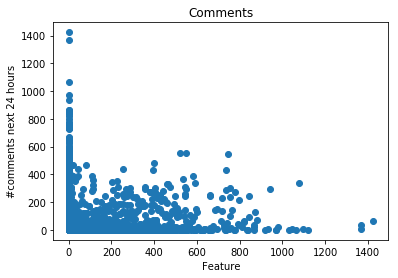

In [70]:
%matplotlib inline

list_x_point = df[52]
list_y_point = df[280]

x_label = "Feature"
y_label = "#comments next 24 hours"
title = "Comments"

plt.figure()
plt.scatter(list_x_point,list_y_point)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()

 By using the log transformation we can reduce the range of the Y

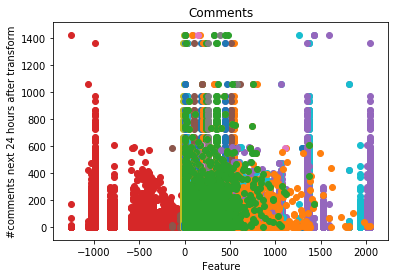

In [62]:
# transformer = FunctionTransformer(lambda x: np.log1p(x))
list_y_point = []
# list_y_point = df[280]
list_x_point = []

for i in range(52):
    list_x_point.append(df[i])
    list_y_point.append(df[280])

labels = range(52)

x_label = "Feature"
y_label = "#comments next 24 hours after transform"
title = "Comments"
for x,y,lab in zip(list_x_point,list_y_point,labels):
    plt.scatter(x,y,label=lab)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()

Most of the features resembling power function such that by having log transformation we could probably improve the accuracy. Another thing that we can capture in here is the weak correlation of each feature to the label. For instance 'green' feature with value 500 relates with a huge range of labels.So, it implicitly saying that each of the feature has a weak correlation with the predicted value so all feature has a contribution to the labels

## B.USING CATEGORIZATION

check the range of the feature data first

In [48]:
df_x = df[list(range(10,20))]

the first label would be from the range (< 25%) , second label (25%<= x   < 50%),third label (50% <= 75%), last label ( > 75% )

In [145]:
df_categorization = copy.deepcopy(df)

# df_categorization.loc[df_categorization[0] > 10, 0] = 0
for i in range(50,62):
    first = np.percentile(df[i], 25)
    second = np.percentile(df[i], 50)
    third = np.percentile(df[i], 75)
    
    df_categorization.loc[df_categorization[i] < first, i] = 0
    df_categorization.loc[(df_categorization[i] >= first) & (df_categorization[i] < second), i] = 1
    df_categorization.loc[(df_categorization[i] >= second) & (df_categorization[i] < third), i] = 2
    df_categorization.loc[df_categorization[i] >= third, i] = 3
#     print ("i: %s , first: %s, second: %s, third: %s " % (i, first, second, third))
#     print(df_categorization[i])


In [47]:
column_list = list(range(62))

df_y_categorization = df_categorization[280].astype(np.int64)
df_x_categorization = df_categorization[column_list].astype(np.int64)
X_train, X_test, Y_train, Y_test = train_test_split(df_x_categorization.as_matrix(), df_y_categorization.as_matrix(),
                                                    test_size=0.05, random_state=0)

model = RandomForestRegressor(n_estimators = 100,n_jobs =-1,oob_score=True)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_train)
print("msqr: %s" % math.sqrt(mean_squared_error(Y_train, Y_pred)))
print ("score: %s" % model.score(X_test,Y_test))

msqr: 24.1768903168
score: 0.303719851631


We have tried using categorization but end up with value loss. so it means we cannot reduce any value again.

# 3.DATA MINING

In here we found 2 possibilities of data transformation. Firstly by using log function for the features and secondly change certain feature to rate instead, the reason behind this is we want to remove the relation with base time for that particular feature

#### Log function is simply:
np.log1p(df_y) or np.log2(df_y)

#### Rate Transformation function

In [44]:
HOUR_PER_DAY = 24
ZERO = 0
ONE = 1

df_rate = copy.deepcopy(df)
df2 = copy.deepcopy(df_test)

df_rate[281] = np.array([HOUR_PER_DAY for i in range(len(df))])
df_rate[282] = np.array([ ZERO for i in range(len(df))])
df_rate[283] = np.array([ ONE for i in range(len(df))])

df2[281] = np.array([HOUR_PER_DAY for i in range(len(df2))])
df2[282] = np.array([ ZERO for i in range(len(df2))])
df2[283] = np.array([ ONE for i in range(len(df2))])

for k in range(6):
    
    df_rate[10*k+0] = df_rate[10*k+0] / (df_rate[60]+df_rate[283])
    df_rate[10*k+5] = df_rate[10*k+5] / (df_rate[60]+df_rate[283])
    df2[10*k+0] = df2[10*k+0] / (df2[60]+df2[283])
    df2[10*k+5] = df2[10*k+5] / (df2[60]+df2[283])

for k in range(6):
    df_rate[10*k+1] = df_rate[10*k+1] / (np.minimum(df_rate[60],df_rate[281])+df_rate[283])
    df_rate[10*k+6] = df_rate[10*k+6] / (np.minimum(df_rate[60],df_rate[281])+df_rate[283])
    df2[10*k+1] = df2[10*k+1] / (np.minimum(df2[60],df2[281])+df2[283])
    df2[10*k+6] = df2[10*k+6] / (np.minimum(df2[60],df2[281])+df2[283])
    
for k in range(6):
    df_rate[10*k+2] = df_rate[10*k+2] / (np.minimum(np.maximum(df_rate[60] - df_rate[281],df_rate[282]),df_rate[281])+df_rate[283])
    df_rate[10*k+7] = df_rate[10*k+7] / (np.minimum(np.maximum(df_rate[60] - df_rate[281],df_rate[282]),df_rate[281])+df_rate[283])
    df2[10*k+2] = df2[10*k+2] / (np.minimum(np.maximum(df2[60] - df2[281],df2[282]),df2[281])+df2[283])
    df2[10*k+7] = df2[10*k+7] / (np.minimum(np.maximum(df2[60] - df2[281],df2[282]),df2[281])+df2[283])
    
for k in range(6):
    df_rate[10*k+3] = df_rate[10*k+3] / (np.minimum(df_rate[60],df_rate[281])+df_rate[283])
    df_rate[10*k+8] = df_rate[10*k+8] / (np.minimum(df_rate[60],df_rate[281])+df_rate[283])
    df2[10*k+3] = df2[10*k+3] / (np.minimum(df2[60],df2[281])+df2[283])
    df2[10*k+8] = df2[10*k+8] / (np.minimum(df2[60],df2[281])+df2[283])


df_rate[280] = df_rate[280] / (df_rate[281]+df_rate[283])
df2[280] = df2[280] / (df2[281]+df2[283])

df_rate = df_rate.fillna(0)
df2 = df2.fillna(0)

## 3.A. Algorithm Comparison

In [84]:
column_list = list(range(62))

list_model = [
                {"name": "Linear Regression", "model": LinearRegression(n_jobs = -1)}, 
                {"name": "Random Forest Regression", "model": RandomForestRegressor(n_estimators = 50,n_jobs =-1,oob_score=True)},
                {"name": "Gradient Boosting", "model": GradientBoostingRegressor(loss = 'huber',n_estimators = 100)}]


for obj in list_model:
    
    df_y = df[280]
    df_y_test = df_test[280]
    
    df_x = df[column_list]
    df_x_test = df_test[column_list]
    
    df_x_rate = df_rate[column_list]
    df_x_test_rate = df2[column_list]
    
    df_y_rate = df_rate[280]
    df_y_rate_test = df2[280]
    
    x_train, x_test, y_train, y_test, y_trans_train, y_trans_test = df_x, df_x_test, df_y, df_y_test, np.log1p(1+df_y), np.log1p(1+df_y_test)
    
    x_train_rate, x_test_rate, y_train_rate, y_test_rate = df_x_rate, df_x_test_rate, df_y_rate, df_y_rate_test
    
    model = obj["model"]
    model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    
    print "%s: " % obj.get("name")
    print "mse: %s" % math.sqrt(mean_squared_error(y_train, y_pred))
    print "r2: %s" % model.score(x_test, y_test)

    model.fit(x_train,y_trans_train)
    y_pred = model.predict(x_test)
    
    print "\n%s with Power Function: " % obj["name"]
    print "mse: %s " % math.sqrt(mean_squared_error(np.exp(y_trans_test), np.exp(y_pred)))
    print 'r2 score: %s ' % r2_score(np.exp(y_trans_test)-1, np.exp(y_pred)-1)
#     print 'r2 score without modif: %s ' % model.score(x_test,y_trans_test)
    
    model.fit(x_train_rate, y_train_rate)
    y_pred = model.predict(x_test_rate)
    
    print "\n%s with Rate function: " % obj["name"]
    print "mse: %s " % math.sqrt(24*mean_squared_error(y_test_rate, y_pred))
    print "r2: %s" % model.score(x_test_rate, y_trans_test)

    y_trans = np.log1p(y_train_rate)
    y_trans_test = np.log1p(y_test_rate)
    model.fit(x_train_rate, y_trans)
    y_pred = model.predict(x_test_rate)
    
    print "\n%s with Rate and Power transformation function: "% obj["name"]
    print "mse: %s " % math.sqrt(24*mean_squared_error(y_test_rate, np.exp(y_pred)-1))
    print 'r2 score: %s ' % r2_score(y_test_rate, np.exp(y_pred)-1)
#     print 'r2 score without modif: %s \n' % model.score(x_test_rate,y_trans_test)
    
    print '--------------------------------------------------------------'

Linear Regression: 
mse: 30.172093081
r2: 0.314770922577

Linear Regression with Power Function: 
mse: 58.5238017861 
r2 score: -2.65324457086 

Linear Regression with Rate function: 
mse: 4.9143576552 
r2: -1.09115269497

Linear Regression with Rate and Power transformation function: 
mse: 5.23377082789 
r2 score: 0.239127538035 
--------------------------------------------------------------
Random Forest Regression: 
mse: 10.362402295
r2: 0.406490831066

Random Forest Regression with Power Function: 
mse: 22.661906848 
r2 score: 0.452219477195 

Random Forest Regression with Rate function: 
mse: 4.63204082055 
r2: -1.02157874213

Random Forest Regression with Rate and Power transformation function: 
mse: 4.32139367519 
r2 score: 0.481283424953 
--------------------------------------------------------------
Gradient Boosting: 
mse: 25.4881122826
r2: 0.391952658084

Gradient Boosting with Power Function: 
mse: 23.8224412976 
r2 score: 0.39467833638 

Gradient Boosting with Rate functio

with linear regression it is making the prediction extremely bad, - means it is worse than deduce the value as the mean

Summing up in here, Linear regression with transformation function perform worse than non-transformation function because as we can see in the visualization part that there is barely correlation between feature and the number of comments given. On the other hand, the random forest regression with transformation function is better than the non-transformed one -> we deduce this is caused by the less range of the comments number.

## USING NEURAL NETWORK

Using neural network should give good result if there is a correlation between feature and the number of comments, but as we can see from the visualization part the correlation between feature and label quite poor, meaning the result of NN would be worse.